In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set_context("talk")

In [2]:
%%bash

dx download -f data/supplementary_dataset_11_full_constraint_metrics.tsv -o ../data/

In [3]:
df = pd.read_csv("../outputs/expected_variants_stats_no_cpg.tsv", sep="\t")
df = df[["enst","csq","n_pos","prop_exp","n_exp","prop_obs","n_obs","oe","oe_diff","z","p"]]

In [4]:
df = df.set_index(["enst","csq"]).unstack("csq")
df.columns = df.columns.swaplevel(0,1)
df.sort_index(axis=1, level=0, inplace=True)

In [5]:
df.shape

(19623, 27)

In [6]:
pli = pd.read_csv("../data/supplementary_dataset_11_full_constraint_metrics.tsv", sep="\t")
pli = pli.set_index("transcript")

In [7]:
df = df.join(pli[["pLI", "oe_lof_upper"]], how="left")

/tmp/ipykernel_176/4184005028.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  df = df.join(pli[["pLI", "oe_lof_upper"]], how="left")


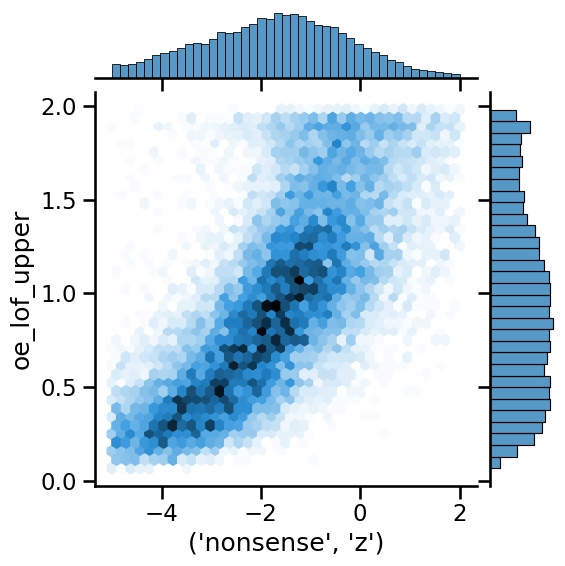

In [8]:
g = sns.jointplot(data=df[df["nonsense", "z"].between(-5,2)],
            x=("nonsense","z"),
            y="oe_lof_upper",
            kind="hex",
                 )

In [9]:
m1 = df["synonymous","n_obs"] > 10
m2 = df["synonymous","z"] >= -1
m3 = df["missense","n_obs"] > 10

df = df[m1 & m2 & m3]
df.shape

(14473, 29)

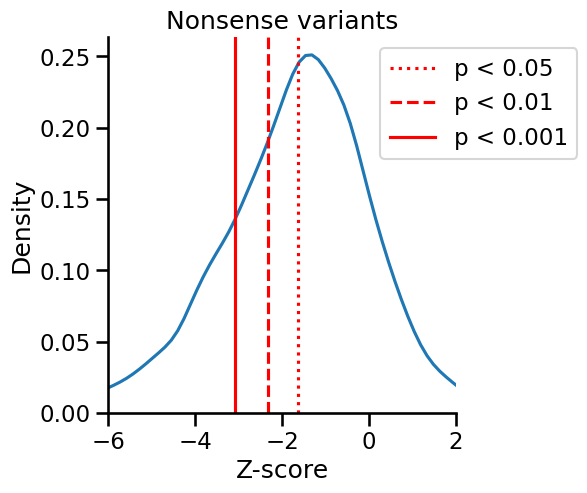

In [10]:
g = sns.displot(kind="kde",
                data=df,
                x=("nonsense","z")
               )
g.set(xlim=(-6,2),
      title="Nonsense variants",
      xlabel="Z-score",
     )

plt.axvline(x=-1.645, color="r", linestyle=":", label = "p < 0.05")
plt.axvline(x=-2.326, color="r", linestyle="--", label = "p < 0.01")
plt.axvline(x=-3.09, color="r", linestyle="-", label = "p < 0.001")

plt.legend(bbox_to_anchor = (0.75, 1), loc = 'upper left')


In [11]:
p_vals = df[[("nonsense","n_obs"), ("nonsense","p")]].copy()
p_vals.columns = ["n_obs","p"]
p_vals["p_bin"] = pd.cut(p_vals["p"], bins=[0,0.001,0.01,0.05,1])
p_stats = p_vals.groupby("p_bin").agg({"p":"count"})
p_stats["none_observed"] = p_vals.groupby("p_bin")["n_obs"].apply(lambda x: (x==0).sum())
p_stats

,p,none_observed
p_bin,,
"(0.0, 0.001]",2998,249
"(0.001, 0.01]",1789,126
"(0.01, 0.05]",2165,141
"(0.05, 1.0]",7521,50


## NMD

In [12]:
nmd = pd.read_csv("../outputs/expected_variants_stats_no_cpg_nmd.tsv", sep="\t")

In [13]:
nmd = nmd.set_index(["enst","csq","nmd"]).unstack(["csq", "nmd"])
nmd.columns = nmd.columns.swaplevel(0,2).swaplevel(0,1)
nmd.sort_index(axis=1, level=[0,1], inplace=True)

### What comparisons would we like to make?
We want to identify transcripts which are:
- Constrained for nonsense variants in general
- Specifically constrained for NMD-target regions
- Specifically constrained for distal NMD-escape, but not NMD-target regions
- Specifically constrained for long exon NMD-escape, but not NMD-target regions
- Constrained for both distal NMD-escape and long exon NMD-escape, but not NMD-target regions

- (Probably we are not powered to detect start_proximal constraint)

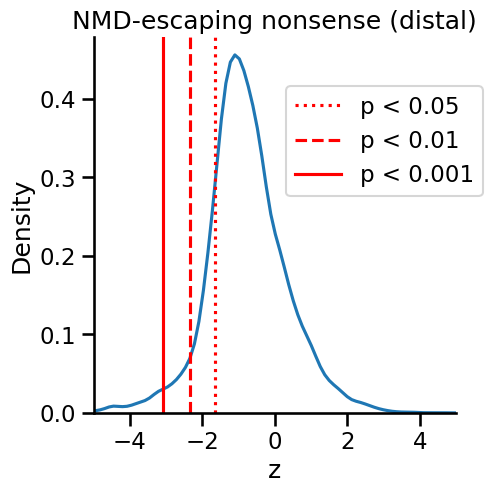

In [14]:
g = sns.displot(kind="kde",
            data=nmd[("nonsense", "distal_nmd")],
            x = "z"
           )
g.set(title="NMD-escaping nonsense (distal)",
      xlim=(-5,5))

plt.axvline(x=-1.645, color="r", linestyle=":", label = "p < 0.05")
plt.axvline(x=-2.326, color="r", linestyle="--", label = "p < 0.01")
plt.axvline(x=-3.09, color="r", linestyle="-", label = "p < 0.001")

plt.legend(bbox_to_anchor = (0.5, 0.9), loc = 'upper left')

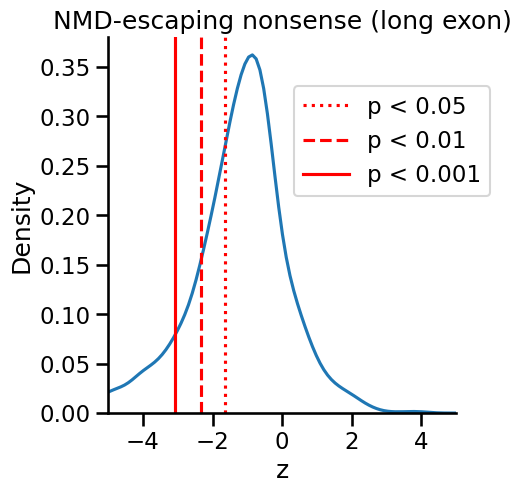

In [15]:
g = sns.displot(kind="kde",
            data=nmd[("nonsense", "long_exon")],
            x = "z"
           )
g.set(title="NMD-escaping nonsense (long exon)",
      xlim=(-5,5))

plt.axvline(x=-1.645, color="r", linestyle=":", label = "p < 0.05")
plt.axvline(x=-2.326, color="r", linestyle="--", label = "p < 0.01")
plt.axvline(x=-3.09, color="r", linestyle="-", label = "p < 0.001")

plt.legend(bbox_to_anchor = (0.5, 0.9), loc = 'upper left')

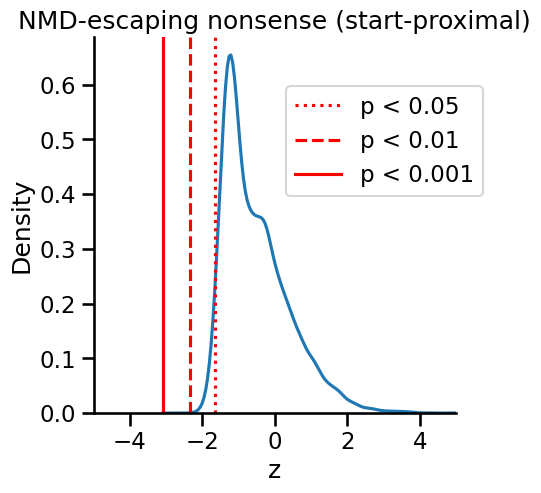

In [16]:
g = sns.displot(kind="kde",
            data=nmd[("nonsense", "start_proximal")],
            x = "z"
           )
g.set(title="NMD-escaping nonsense (start-proximal)",
      xlim=(-5,5))

plt.axvline(x=-1.645, color="r", linestyle=":", label = "p < 0.05")
plt.axvline(x=-2.326, color="r", linestyle="--", label = "p < 0.01")
plt.axvline(x=-3.09, color="r", linestyle="-", label = "p < 0.001")

plt.legend(bbox_to_anchor = (0.5, 0.9), loc = 'upper left')

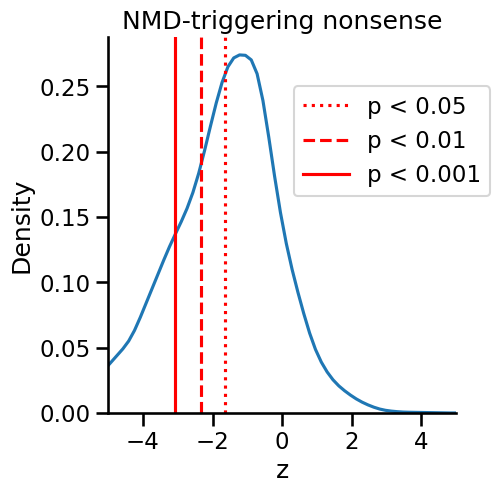

In [17]:
g = sns.displot(kind="kde",
            data=nmd[("nonsense", "nmd_target")],
            x = "z"
           )
g.set(title="NMD-triggering nonsense",
      xlim=(-5,5))

plt.axvline(x=-1.645, color="r", linestyle=":", label = "p < 0.05")
plt.axvline(x=-2.326, color="r", linestyle="--", label = "p < 0.01")
plt.axvline(x=-3.09, color="r", linestyle="-", label = "p < 0.001")

plt.legend(bbox_to_anchor = (0.5, 0.9), loc = 'upper left')

### How can we fairly exclude low-coverage transcripts?
Using a synonymous Z-score cutoff

### Distal NMD-escape

In [18]:
region = "distal_nmd"
df = nmd.copy()

# Exclude transcripts with low synonymous Z-scores
df = df[df[("synonymous", region, "z")] > -1]
print(f"Remaining transcripts: {len(df)}")

# Summarise the number of transcripts meeting p-value thresholds
def get_p_stats(df, region):
    p_vals = df[[("nonsense", region,"n_obs"), ("nonsense", region,"p")]].copy()
    p_vals.columns = ["n_obs","p"]
    p_vals["p_bin"] = pd.cut(p_vals["p"], bins=[0,0.001,0.01,0.05,1])
    p_stats = p_vals.groupby("p_bin").agg({"p":"count"})
    p_stats["none_observed"] = p_vals.groupby("p_bin")["n_obs"].apply(lambda x: (x==0).sum())
    return p_stats

p_stats = get_p_stats(df, region)
p_stats

Remaining transcripts: 15096


,p,none_observed
p_bin,,
"(0.0, 0.001]",290,59
"(0.001, 0.01]",414,82
"(0.01, 0.05]",1439,750
"(0.05, 1.0]",12837,3489


### Long exon NMD-escape

In [19]:
region = "long_exon"
df = nmd.copy()

# Exclude transcripts with low synonymous Z-scores
df = df[df[("synonymous", region, "z")] > -1]
print(f"Remaining transcripts: {len(df)}")

# Summarise the number of transcripts meeting p-value thresholds
p_stats = get_p_stats(df, region)
p_stats

Remaining transcripts: 2903


,p,none_observed
p_bin,,
"(0.0, 0.001]",266,56
"(0.001, 0.01]",221,71
"(0.01, 0.05]",397,156
"(0.05, 1.0]",1949,644


### NMD-targeted regions

In [20]:
region = "nmd_target"
df = nmd.copy()

# Exclude transcripts with low synonymous Z-scores
df = df[df[("synonymous", region, "z")] > -1]
print(f"Remaining transcripts: {len(df)}")

# Summarise the number of transcripts meeting p-value thresholds
p_stats = get_p_stats(df, region)
p_stats

Remaining transcripts: 12087


,p,none_observed
p_bin,,
"(0.0, 0.001]",1976,275
"(0.001, 0.01]",1309,196
"(0.01, 0.05]",1813,314
"(0.05, 1.0]",6926,962


In [71]:
def region_constraint(df, region):
    m1 = df["synonymous",region,"z"]>-1
    m2 = df["nonsense",region,"p"]<0.001
    m3 = df["nonsense",region,"p"]<0.01
    m4 = df["nonsense",region,"n_obs"]==0
    m5 = df["nonsense","nmd_target", "p"] > 0.05
    m6 = df["nonsense","nmd_target", "p"].isna()

    return df[(m1 & (m2 | (m3 & m4))) & (m5 | m6)]

a = region_constraint(nmd, "distal_nmd")

In [ ]:
distal_nmd = nmd[(nmd["synonymous","distal_nmd","z"]>-1) & ( (nmd["nonsense","distal_nmd","p"]<0.001) | ( (nmd["nonsense","distal_nmd","p"]<0.01) & (nmd["nonsense","distal_nmd","n_obs"]==0) ) )].copy()
long_exon = nmd[(nmd["synonymous","long_exon","z"]>-1) & ( (nmd["nonsense","long_exon","p"]<0.001) | ( (nmd["nonsense","long_exon","p"]<0.01) & (nmd["nonsense","long_exon","n_obs"]==0) ) )].copy()
start_proximal = nmd[(nmd["synonymous","start_proximal","z"]>-1) & ( (nmd["nonsense","start_proximal","p"]<0.001) | ( (nmd["nonsense","start_proximal","p"]<0.01) & (nmd["nonsense","start_proximal","n_obs"]==0) ) )].copy()
nmd_target = nmd[(nmd["synonymous","nmd_target","z"]>-1) & ( (nmd["nonsense","nmd_target","p"]<0.001) | ( (nmd["nonsense","nmd_target","p"]<0.01) & (nmd["nonsense","nmd_target","n_obs"]==0) ) )].copy()

In [22]:
print(distal_nmd[(distal_nmd["nonsense","nmd_target", "p"] > 0.05) | (distal_nmd["nonsense","nmd_target", "p"].isna())].shape)
print(long_exon[(long_exon["nonsense","nmd_target", "p"] > 0.05) | (long_exon["nonsense","nmd_target", "p"].isna())].shape)
print(start_proximal[(start_proximal["nonsense","nmd_target", "p"] > 0.05) | (start_proximal["nonsense","nmd_target", "p"].isna())].shape)

(215, 108)
(25, 108)
(0, 108)


In [23]:
distal_nmd[distal_nmd["nonsense","nmd_target", "p"] > 0.05].sort_values(("nonsense","distal_nmd","z"))

csq                  missense                                      \
nmd                distal_nmd                                       
                           mu    n_exp   n_obs    n_pos        oe   
enst                                                                
ENST00000378024  3.379658e-09  3863.53  4249.0  38608.0  1.099771   
ENST00000316407  3.276946e-09  1388.74  1264.0  14259.0  0.910178   
ENST00000326441  3.250845e-09   847.79   819.0   8766.0  0.966041   
ENST00000369042  3.347890e-09   483.41   350.0   4871.0  0.724023   
ENST00000322527  3.128953e-09  4324.75  4497.0  46236.0  1.039829   
...                       ...      ...     ...      ...       ...   
ENST00000615612  3.202072e-09    81.98    26.0    859.0  0.317151   
ENST00000376008  3.346443e-09    98.81    89.0    996.0  0.900719   
ENST00000282141  3.359028e-09    68.18    71.0    685.0  1.041361   
ENST00000241600  3.533330e-09   142.48   121.0   1369.0  0.849242   
ENST00000609713  3.183720e-09    77.21    28.0    813.0  0.362647   

csq                                                                        \
nmd                                                             long_exon   
                            p  prop_exp  prop_obs         z            mu   
enst                                                                        
ENST00000378024  1.000000e+00  0.100071  0.110055  6.537221  0.000000e+00   
ENST00000316407  2.132068e-04  0.097394  0.088646 -3.523173  0.000000e+00   
ENST00000326441  1.490911e-01  0.096713  0.093429 -1.040340  0.000000e+00   
ENST00000369042  8.112991e-11  0.099243  0.071854 -6.393379  0.000000e+00   
ENST00000322527  9.970302e-01  0.093536  0.097262  2.751099  0.000000e+00   
...                       ...       ...       ...       ...           ...   
ENST00000615612  3.987326e-11  0.095442  0.030268 -6.501078  3.470704e-09   
ENST00000376008  1.492555e-01  0.099205  0.089357 -1.039632  0.000000e+00   
ENST00000282141  6.405345e-01  0.099533  0.103650  0.359888  0.000000e+00   
ENST00000241600  2.863925e-02  0.104076  0.088386 -1.901180  0.000000e+00   
ENST00000609713  1.972311e-09  0.094964  0.034440 -5.886499  3.343857e-09   

csq              ... synonymous                                               \
nmd              ... nmd_target start_proximal                                 
                 ...          z             mu  n_exp n_obs  n_pos        oe   
enst             ...                                                           
ENST00000378024  ...   1.689120   4.639558e-09  13.82  12.0  104.0  0.868307   
ENST00000316407  ...  -1.314964   4.224330e-09  11.11  10.0   91.0  0.900090   
ENST00000326441  ...   0.963302   4.181245e-09  11.85   7.0   98.0  0.590717   
ENST00000369042  ...  -0.320690   3.920070e-09  11.42  10.0  100.0  0.875657   
ENST00000322527  ...   2.030461   4.214966e-09  10.60  10.0   87.0  0.943396   
...              ...        ...            ...    ...   ...    ...       ...   
ENST00000615612  ...   1.361718   4.611821e-09  14.80  11.0  112.0  0.743243   
ENST00000376008  ...  -0.702643   4.612020e-09  12.95  14.0   98.0  1.081081   
ENST00000282141  ...  -0.012747   5.028851e-09  12.45  17.0   87.0  1.365462   
ENST00000241600  ...  -0.303786   4.520923e-09  15.19  21.0  117.0  1.382488   
ENST00000609713  ...  -0.861646   4.452158e-09  12.16   9.0   95.0  0.740132   

csq                                                      
nmd                                                      
                        p  prop_exp  prop_obs         z  
enst                                                     
ENST00000378024  0.299295  0.132909  0.115385 -0.526429  
ENST00000316407  0.361156  0.122086  0.109890 -0.355369  
ENST00000326441  0.066316  0.120963  0.071429 -1.503805  
ENST00000369042  0.328104  0.114156  0.100000 -0.445155  
ENST00000322527  0.422015  0.121842  0.114943 -0.196741  
...                   ...       ...       ...       ...  
ENST00000615612  0.144233  